<a href="https://colab.research.google.com/github/duke-sunshine/Algorithmic-Trading-Finance/blob/main/Session_1_Simple_Moving_Average_Rule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Data 

1.   Install the Alpha Vantage API
2.   [Claim your own API Key](https://www.alphavantage.co/support/#api-key)
3.   [Import data from Time Series Stock APIs by specifiying API key and Parameters](https://www.alphavantage.co/documentation/)



Install Alpha Vantage Package

In [ ]:
pip install alpha_vantage

     |████████████████████████████████| 1.3 MB 8.2 MB/s 
     |████████████████████████████████| 142 kB 57.6 MB/s 
     |████████████████████████████████| 294 kB 68.7 MB/s 


In [ ]:
from alpha_vantage.timeseries import TimeSeries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Program import data class


In [ ]:
class Data:
  def __init__(self,API_key, symbol, interval):
    self.API_key = API_key
    self.symbol = symbol
    self.interval = interval
  def import_data(self):
    ts = TimeSeries(key=self.API_key, output_format='pandas')
    data=ts.get_intraday(self.symbol, interval = self.interval, outputsize = 'full') # We use 5-min interval to determine the time when traders make investment decisions.
    data[0].rename(columns={'1. open':'open', '2. high':'high', '3. low':'low', '4. close':'close', '5. volume':'volume'}, inplace = True)
    all_df = data[0]
    num = int(3/5 * all_df.shape[0])
    all_df.sort_index(ascending=True, inplace=True)
    df = all_df.iloc[num:].copy()
    return df

return data with specified API and parameters: 

we use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.  

In [ ]:
TSLA=Data('YDWAVBLTFDZ3T4I7','TSLA','5min')
df_TSLA=TSLA.import_data()
df_TSLA.head()

,open,high,low,close,volume
date,,,,,
2021-08-10 19:05:00,708.79,709.00,708.76,709.00,1090.0
2021-08-10 19:15:00,708.99,709.00,708.80,708.80,3608.0
2021-08-10 19:20:00,708.80,708.99,708.50,708.99,3402.0
2021-08-10 19:30:00,708.90,708.90,708.77,708.77,673.0
2021-08-10 19:35:00,708.77,708.77,708.70,708.70,1143.0


In [ ]:
AAPL=Data('YDWAVBLTFDZ3T4I7','AAPL','5min')
df_AAPL=AAPL.import_data()
df_AAPL.head()

,open,high,low,close,volume
date,,,,,
2021-08-10 19:45:00,145.51,145.52,145.50,145.50,5217.0
2021-08-10 19:50:00,145.52,145.52,145.51,145.51,2152.0
2021-08-10 19:55:00,145.52,145.60,145.52,145.60,4384.0
2021-08-10 20:00:00,145.62,145.66,145.60,145.60,7082.0
2021-08-11 04:05:00,145.41,145.41,145.41,145.41,1090.0


# 2. Generate buy and sell signals with Visualizations

Program the signal class

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

```
# 此内容为代码格式
```

The Simple moving average with window $n$ at time $t$:

$SMA_t^n=\frac{1}{n}\sum_{i=t-n+1}^{t}p_i$


In [ ]:
class signal:
  def __init__(self, data, short_window, long_window):
    self.data = data
    self.short_window = short_window
    self.long_window = long_window
  def signals(self):
    signals = pd.DataFrame(index=self.data.index)
    signals = signals.sort_values(by='date')
    signals['signal'] = 0.0
    signals['short_ma'] = self.data['close'].rolling(window=self.short_window, min_periods=self.short_window, center=True, closed='right').mean()
    signals['long_ma'] = self.data['close'].rolling(window=self.long_window, min_periods=self.long_window, center=True, closed='right').mean()  
    signals['signal'][self.short_window:] = np.where(signals['short_ma'][self.short_window:]>signals['long_ma'][self.short_window:], 1.0, 0.0)     
    signals['positions'] = signals['signal'].diff()
    signals =signals.dropna()
    return signals

Return sigals with input data and short and long windows. 

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window =5

Long_window =10

In [ ]:
SMA_TSLA = signal(df_TSLA, 5, 10)
Signal_TSLA =SMA_TSLA.signals()
Signal_TSLA.head()

,signal,short_ma,long_ma,positions
date,,,,
2021-08-10 19:40:00,0.0,708.600,708.694,0.0
2021-08-10 19:50:00,0.0,708.546,708.664,0.0
2021-08-10 19:55:00,0.0,708.536,708.585,0.0
2021-08-10 20:00:00,1.0,708.536,708.380,1.0
2021-08-11 04:10:00,1.0,708.472,708.203,0.0


In [ ]:
SMA_AAPL = signal(df_AAPL, 5, 10)
Signal_AAPL =SMA_AAPL.signals()
Signal_AAPL.head()

,signal,short_ma,long_ma,positions
date,,,,
2021-08-11 04:10:00,0.0,145.376,145.403,0.0
2021-08-11 04:15:00,0.0,145.306,145.374,0.0
2021-08-11 04:20:00,0.0,145.282,145.343,0.0
2021-08-11 04:25:00,0.0,145.260,145.308,0.0
2021-08-11 04:30:00,0.0,145.248,145.270,0.0


define signal visualization class

In [ ]:
class signal_figure:
  def __init__(self, prices, signals, topic):
    self.prices = prices
    self.signals = signals
    self.topic = topic
  def signal_figure(self):
    close = self.prices['close']
    close = close.to_frame()
    close = close.merge(self.signals,how='inner',left_index=True, right_index=True)
    close = close.sort_values(by='date')
    fig = plt.figure(figsize = (18,8))
    plt.plot(close.close, color='g', lw=1., label = 'Stock Price')
    plt.plot(close.short_ma, color='r', lw=1., label = 'Short Window Moving Average')
    plt.plot(close.long_ma, color='b', lw=1., label = 'Long Window Moving Average')
    plt.plot(close.loc[close.positions == 1.0].index, close.short_ma[close.positions == 1.0], '^', markersize=5, color='green',label = 'buying signal')
    plt.plot(close.loc[close.positions == -1.0].index, close.long_ma[close.positions == -1.0],'v', markersize=5, color='red',label = 'selling signal')
    plt.xlabel('Date')
    plt.ylabel('Dollars')
    plt.title(self.topic + ' Price')
    plt.legend()
    plt.show()
    return close

Return plots with input data.

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window =5 

Long_window =10

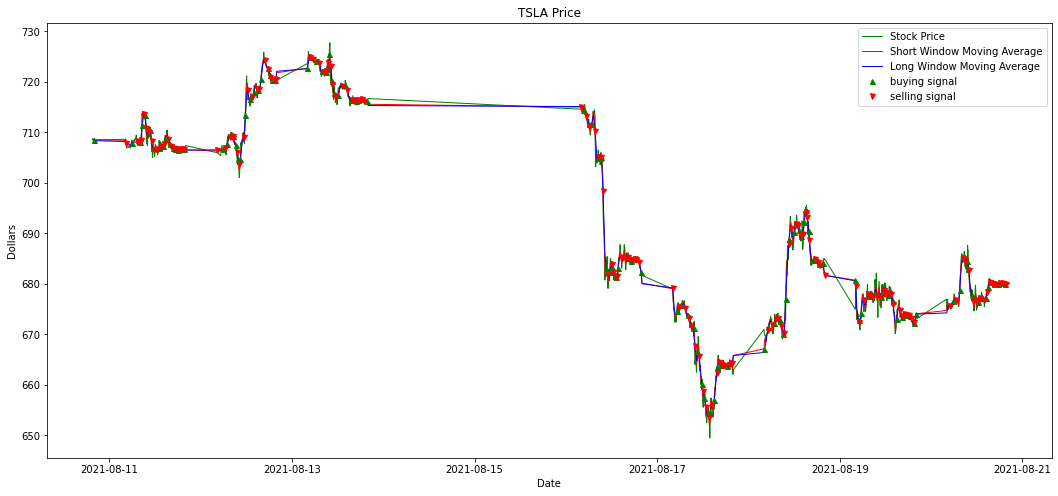

In [ ]:
SMA_TSLA_Figure = signal_figure(df_TSLA, Signal_TSLA, 'TSLA')
SMA_Signal_TSLA =SMA_TSLA_Figure.signal_figure()

In [ ]:
SMA_Signal_TSLA.head()

,close,signal,short_ma,long_ma,positions
date,,,,,
2021-08-10 19:40:00,708.70,0.0,708.600,708.694,0.0
2021-08-10 19:50:00,708.33,0.0,708.546,708.664,0.0
2021-08-10 19:55:00,708.50,0.0,708.536,708.585,0.0
2021-08-10 20:00:00,708.50,1.0,708.536,708.380,1.0
2021-08-11 04:10:00,708.65,1.0,708.472,708.203,0.0


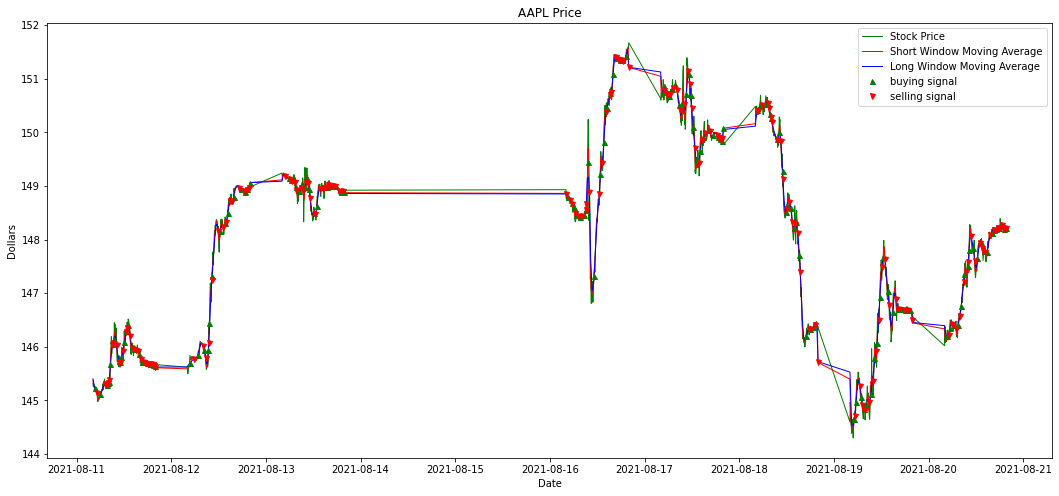

In [ ]:
SMA_AAPL_Figure = signal_figure(df_AAPL, Signal_AAPL, 'AAPL')
SMA_Signal_AAPL =SMA_AAPL_Figure.signal_figure()

In [ ]:
SMA_Signal_AAPL.head()

,close,signal,short_ma,long_ma,positions
date,,,,,
2021-08-11 04:10:00,145.32,0.0,145.376,145.403,0.0
2021-08-11 04:15:00,145.26,0.0,145.306,145.374,0.0
2021-08-11 04:20:00,145.29,0.0,145.282,145.343,0.0
2021-08-11 04:25:00,145.25,0.0,145.260,145.308,0.0
2021-08-11 04:30:00,145.29,0.0,145.248,145.270,0.0


# 3. Generate Return of Investment and Portfolio Flows (cash, holding and total)

program the portfolio class

In [ ]:
class portfolio:
  def __init__(self,data,topic,initial_capital=10000,max_buy=10000000,max_sell=10000000):
    self.data = data
    self.topic = topic
    self.initial_capital = initial_capital
    self.max_buy = max_buy
    self.max_sell = max_sell
  def portfolios(self):
    management = self.data
    prices = self.data['close']
    states = self.data['positions']
    states_buy = []
    states_sell = []
    cashes = []
    stocks = []
    holdings = []
    cash = self.initial_capital
    stock = 0
    holding = 0
    state = 0
    def buy(i,cash,stock,price):
      shares = cash // price #shares to buy in integer
      if shares<1:
        print('order %d: total cash %f, not enough to buy 1 share at price %f' % (i, cash, price))
      else:
        if shares>self.max_buy:
            buy_units = self.max_buy
        else:
            buy_units = shares
        cost = buy_units*price
        cash -= cost
        stock += buy_units
        holding = stock*price
        print('index %d: buy %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, buy_units, price, cash, stock, holding))
        return cash, stock, holding   
    def sell(i,cash, stock,price):
       if stock == 0:
         print('index %d: cannot sell anything, currentstock 0' % (i))
       else:
         if stock > self.max_sell:
            sell_units = self.max_sell
         else: 
            sell_units = stock
         stock -=sell_units
         revenue = sell_units*price
         cash += revenue
         holding = stock*price
         print('index %d: sell %d units at price %f, current cash %f, current stock %f,current holding %f' % (i, sell_units, price, cash, stock, holding))
         return cash, stock, holding
    for i in range(0,management.shape[0]):
      
      state = states[i]
      price = prices[i]
      if state == 1:
        cash, stock, holding = buy(i, cash, stock, price)
        states_buy.append(i)
      elif state == -1:
        cash, stock, holding = sell(i,cash, stock, price)
      states_sell.append(i)
      cashes.append(cash)
      stocks.append(stock)
      holdings.append(holding)
    
    management['cash']=cashes
    management['stock']=stocks
    management['holding']=holdings
    management['total']=management['cash']+management['holding']
    management['roi']=(management['total']-self.initial_capital)/self.initial_capital
    fig, (ax1, ax2) = plt.subplots(2,1, sharey=False)
    ax1=management[['holding', 'cash', 'total']].plot(figsize=(14, 10),legend=True)
    ax1.set_title("Visualization of " + self.topic + " Portfolio Flows")
    ax2=management[['roi']].plot(figsize=(14, 10),legend=True)
    ax2.set_title(self.topic + " Return of Investment")
    return management
 

Return plots with input data.

We use Tesla (TSLA) and Apple (AAPL) with 5-min time interval as case studies.

Short_window =5

Long_window =10

index 3: buy 14 units at price 708.500000, current cash 81.000000, current stock 14.000000,current holding 9919.000000
index 6: sell 14 units at price 708.010000, current cash 9993.140000, current stock 0.000000,current holding 0.000000
index 13: buy 14 units at price 708.480000, current cash 74.420000, current stock 14.000000,current holding 9918.720000
index 19: sell 14 units at price 707.700000, current cash 9982.220000, current stock 0.000000,current holding 0.000000
index 23: buy 14 units at price 708.230000, current cash 67.000000, current stock 14.000000,current holding 9915.220000
index 24: sell 14 units at price 708.000000, current cash 9979.000000, current stock 0.000000,current holding 0.000000
index 25: buy 14 units at price 708.200000, current cash 64.200000, current stock 14.000000,current holding 9914.800000
index 27: sell 14 units at price 708.100000, current cash 9977.600000, current stock 0.000000,current holding 0.000000
index 31: buy 13 units at price 713.750000, cu

,close,signal,short_ma,long_ma,positions,cash,stock,holding,total,roi
date,,,,,,,,,,
2021-08-10 19:40:00,708.70,0.0,708.600,708.694,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-10 19:50:00,708.33,0.0,708.546,708.664,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-10 19:55:00,708.50,0.0,708.536,708.585,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-10 20:00:00,708.50,1.0,708.536,708.380,1.0,81.0,14.0,9919.0,10000.0,0.0
2021-08-11 04:10:00,708.65,1.0,708.472,708.203,0.0,81.0,14.0,9919.0,10000.0,0.0


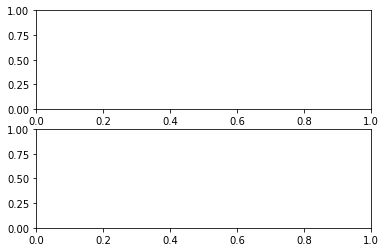

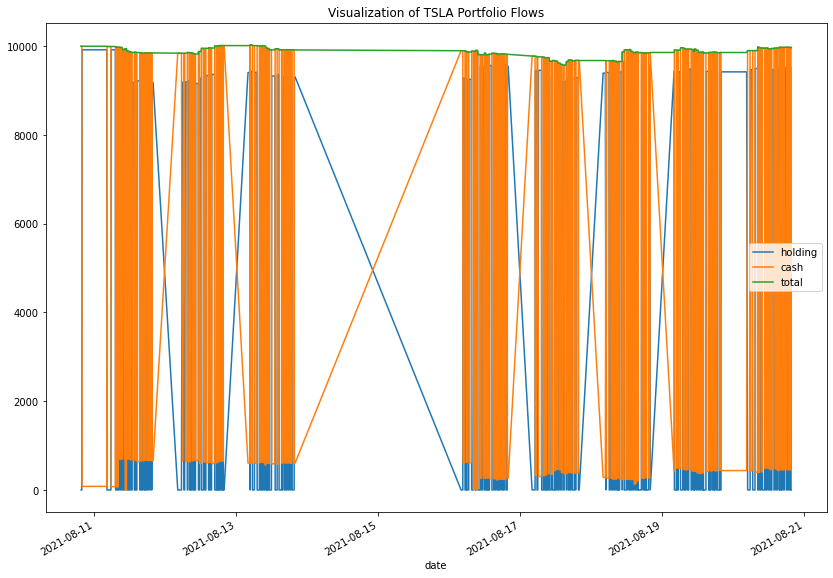

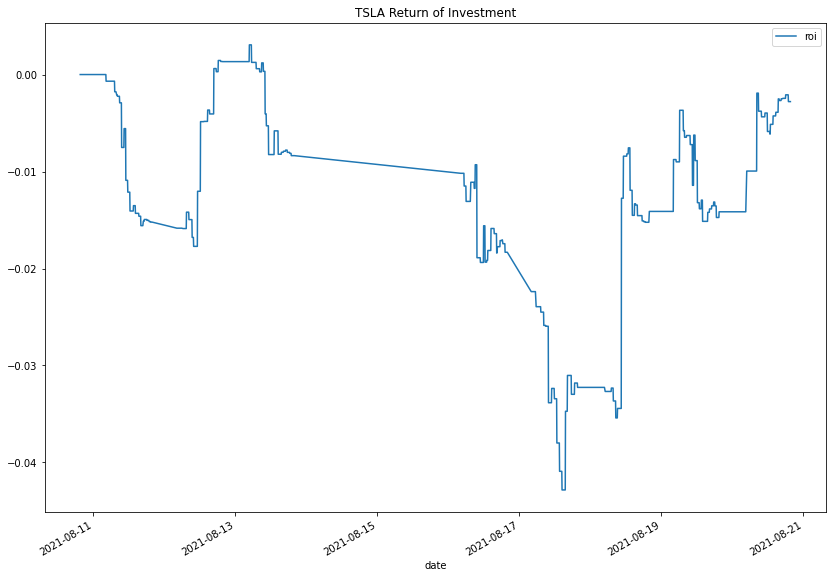

In [ ]:
SMA_TSLA_Portfolio = portfolio(SMA_Signal_TSLA,'TSLA')
TSLA_Portfolio = SMA_TSLA_Portfolio.portfolios()
TSLA_Portfolio.head()

index 5: buy 68 units at price 145.210000, current cash 125.720000, current stock 68.000000,current holding 9874.280000
index 8: sell 68 units at price 145.220000, current cash 10000.680000, current stock 0.000000,current holding 0.000000
index 14: buy 68 units at price 145.170000, current cash 129.120000, current stock 68.000000,current holding 9871.560000
index 25: sell 68 units at price 145.310000, current cash 10010.200000, current stock 0.000000,current holding 0.000000
index 29: buy 68 units at price 145.250000, current cash 133.200000, current stock 68.000000,current holding 9877.000000
index 31: sell 68 units at price 145.330000, current cash 10015.640000, current stock 0.000000,current holding 0.000000
index 33: buy 68 units at price 145.270000, current cash 137.280000, current stock 68.000000,current holding 9878.360000
index 34: sell 68 units at price 145.310100, current cash 10018.366800, current stock 0.000000,current holding 0.000000
index 35: buy 68 units at price 145.40

,close,signal,short_ma,long_ma,positions,cash,stock,holding,total,roi
date,,,,,,,,,,
2021-08-11 04:10:00,145.32,0.0,145.376,145.403,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:15:00,145.26,0.0,145.306,145.374,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:20:00,145.29,0.0,145.282,145.343,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:25:00,145.25,0.0,145.260,145.308,0.0,10000.0,0.0,0.0,10000.0,0.0
2021-08-11 04:30:00,145.29,0.0,145.248,145.270,0.0,10000.0,0.0,0.0,10000.0,0.0


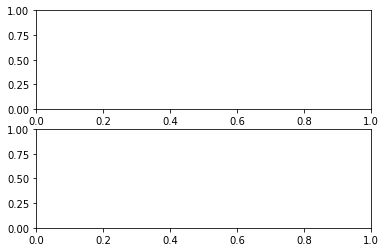

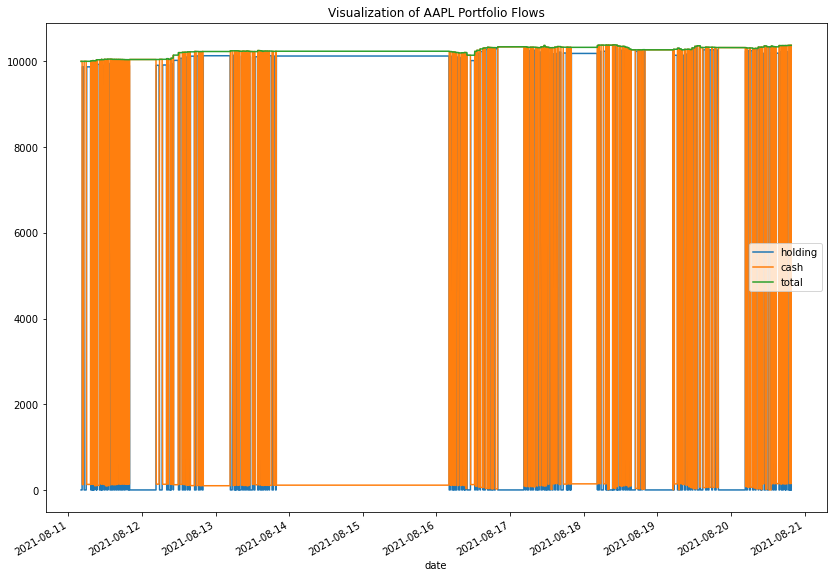

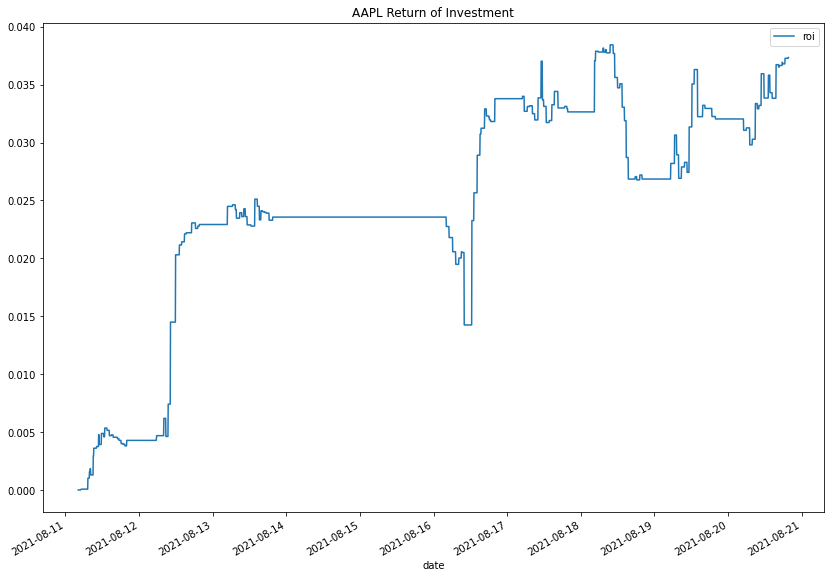

In [ ]:
SMA_AAPL_Portfolio = portfolio(SMA_Signal_AAPL,'AAPL')
AAPL_Portfolio = SMA_AAPL_Portfolio.portfolios()
AAPL_Portfolio.head()

Exponential Moving Average (EMA) is also widely used as an alternative in applying moving average strategy, given by an iterated function, with window $n$ at time $t$:

$EMA_t= \frac{2}{1+n}(p_t - EMA_{t-1}) + EMA_{t-1}, \quad t \geq 2$